In [2]:
import pandas as pd
import numpy as np
# Load the dataset
enso_df = pd.read_csv('../Data/enso_mei_long.csv')
# Display the first few rows of the dataframe and check for missing values
display(enso_df.tail(), enso_df.isnull().sum())
#remove NaN MEI rows
enso_df = enso_df.dropna()
enso_df.tail()

,Year,Month,MEI
535,2023,Aug,0.43
536,2023,Sep,0.59
537,2023,Oct,NaN
538,2023,Nov,NaN
539,2023,Dec,NaN


Year     0
Month    0
MEI      3
dtype: int64

,Year,Month,MEI
532,2023,May,-0.14
533,2023,Jun,0.23
534,2023,Jul,0.25
535,2023,Aug,0.43
536,2023,Sep,0.59


In [3]:
# Convert the 'Year' and 'Month' into a datetime object and set it as the index
enso_df['Date'] = pd.to_datetime(enso_df['Year'].astype(str) + ' ' + enso_df['Month'], format="%Y %b")
enso_df.set_index('Date', inplace=True)

# Drop the original 'Year' and 'Month' columns 
enso_df.drop(['Year', 'Month'], axis=1, inplace=True)

# Ensure the data is sorted in chronological order
enso_df.sort_index(inplace=True)
enso_df.index = pd.DatetimeIndex(enso_df.index.values, freq=enso_df.index.inferred_freq)

# Check the dataframe structure now
display(enso_df.head(), enso_df.tail())

,MEI
1979-01-01,0.47
1979-02-01,0.27
1979-03-01,-0.04
1979-04-01,0.26
1979-05-01,0.35


,MEI
2023-05-01,-0.14
2023-06-01,0.23
2023-07-01,0.25
2023-08-01,0.43
2023-09-01,0.59


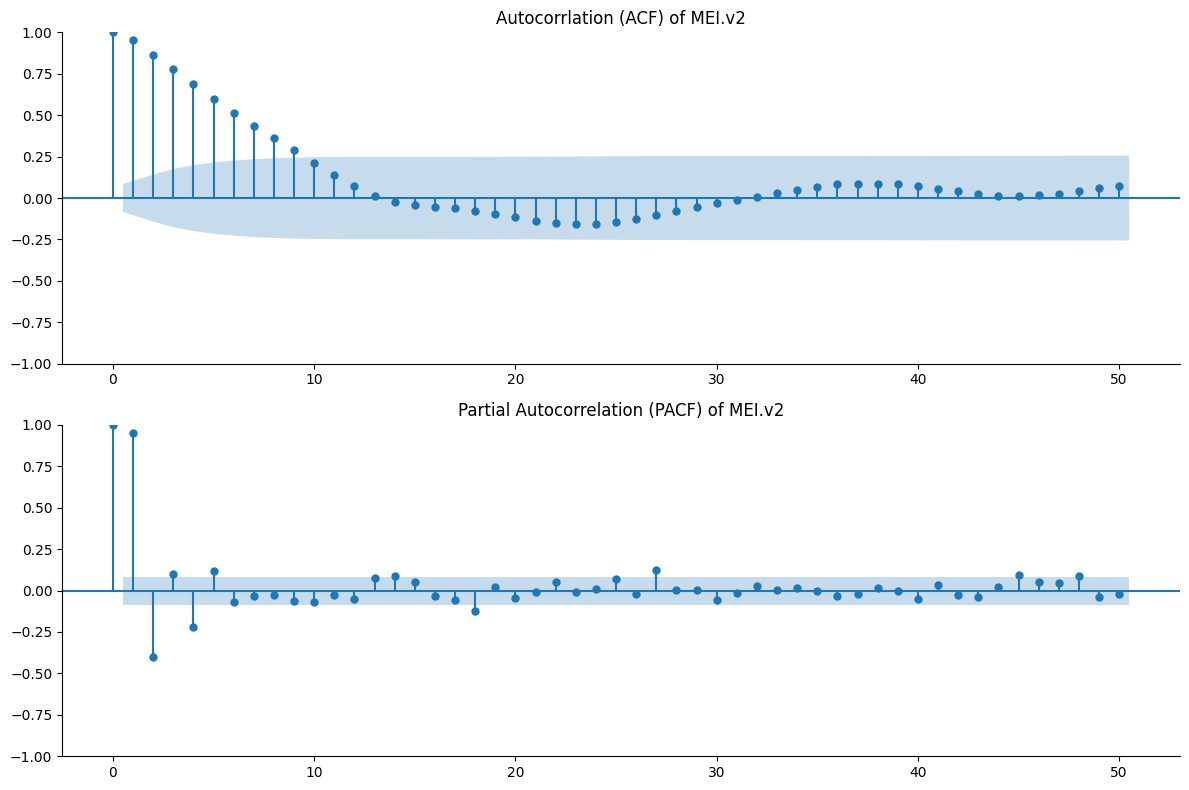

In [4]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
# Plot the Autocorrelation Function (ACF)
plot_acf(enso_df['MEI'], lags=50, ax=ax1, title= "Autocorrlation (ACF) of MEI.v2")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(enso_df['MEI'], lags=50, ax=ax2, title= "Partial Autocorrelation (PACF) of MEI.v2")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.savefig('../Plots/ACF_PACF.png')
plt.tight_layout()
plt.show()


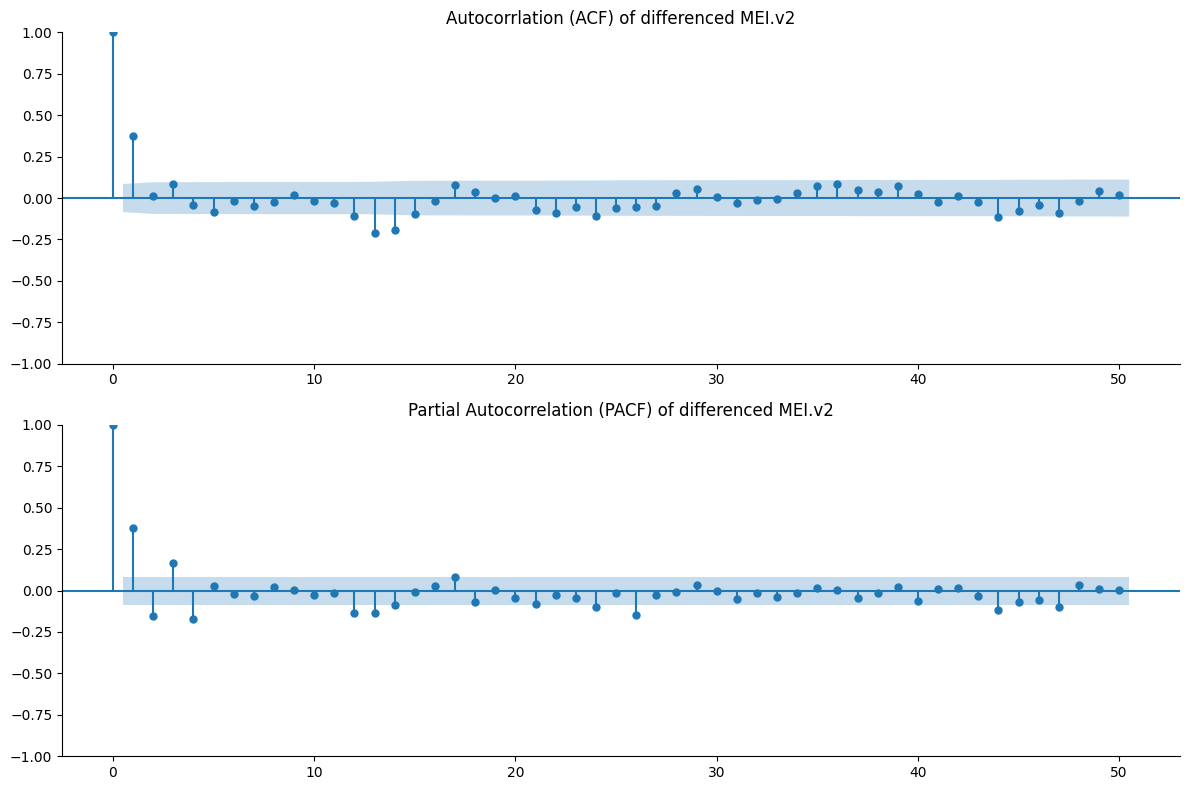

In [5]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd

# Differencing the series once to handle non-stationarity
differenced_series = enso_df['MEI'].diff().dropna()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
# Plot the Autocorrelation Function (ACF)
plot_acf(differenced_series, lags=50, ax=ax1, title= "Autocorrlation (ACF) of differenced MEI.v2")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(differenced_series, lags=50, ax=ax2, title= "Partial Autocorrelation (PACF) of differenced MEI.v2")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.savefig('../Plots/ACF_PACF_diff.png')
plt.tight_layout()
plt.show()

## Fourier

,Frequency,Amplitude
4,0.007449,153.864183
12,0.022346,133.572696
8,0.014898,116.754668
15,0.027933,99.788434
10,0.018622,99.419709
1,0.001862,93.567986
18,0.033520,89.675907
30,0.055866,81.549433
11,0.020484,75.180320
19,0.035382,49.670009


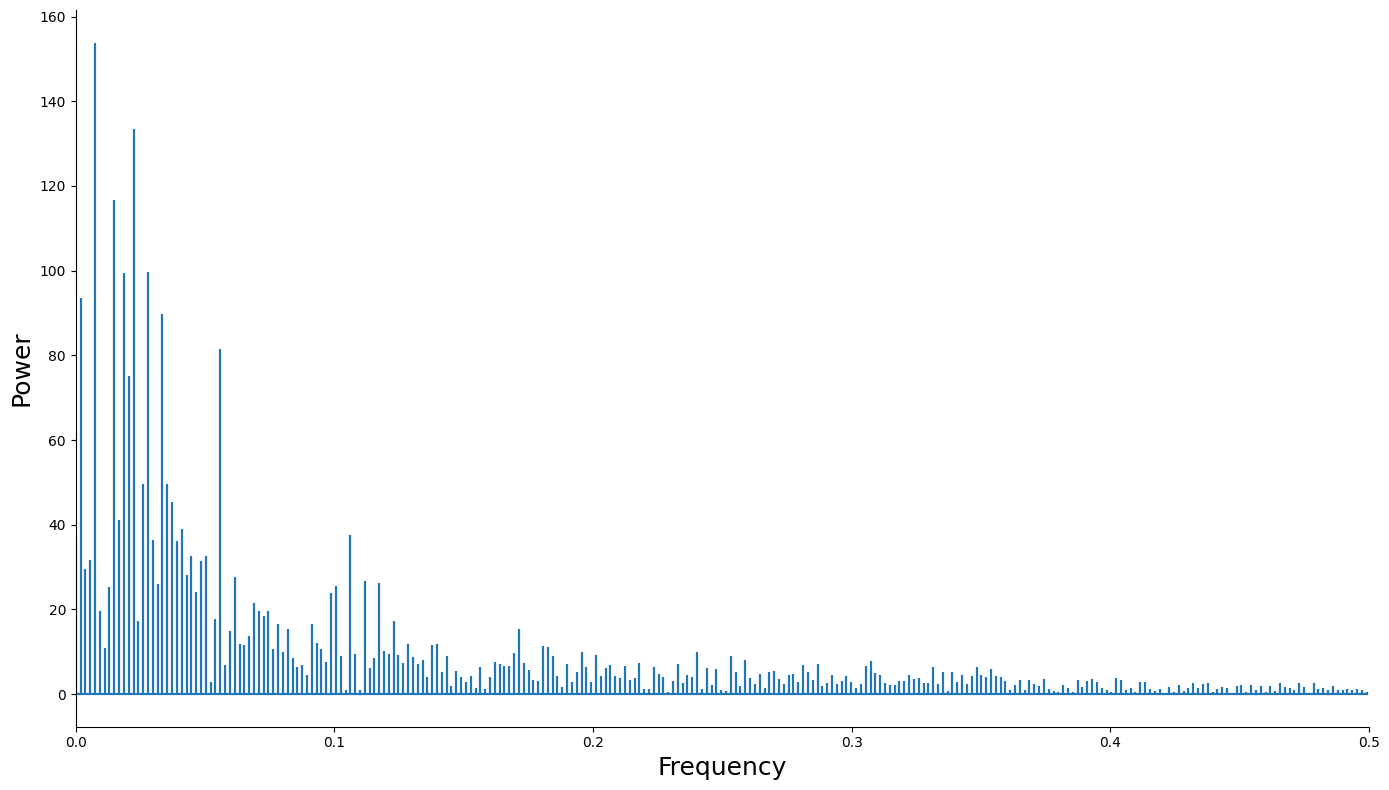

In [38]:
import numpy as np
from scipy.fft import rfft, rfftfreq, irfft
import matplotlib.pyplot as plt
N = enso_df.shape[0]
T = 1.0  # assuming monthly data, so the unit is 'months'
# Compute the fast Fourier Transform (rfft) of the MEI time series
yf = rfft(enso_df['MEI'].values)
# Generate the sample frequencies
xf = rfftfreq(N, T)
# Create a dataframe of frequencies and their corresponding amplitudes
fft_df = pd.DataFrame({'Frequency': xf, 'Amplitude': np.abs(yf)})
fft_df_sorted = fft_df.sort_values(by='Amplitude', ascending=False)
# Display the dominant frequencies
display(fft_df_sorted.head(10))

spectrum = np.abs(yf)
plt.figure(figsize=(14, 8))
plt.stem(xf, spectrum, 'b', markerfmt=" ", basefmt="-b")
plt.stem(xf, spectrum, linefmt='C0-', markerfmt=" ", basefmt="-C0")
# plt.title('Power Spectrum of the Cleaned MEI Data')
plt.xlabel('Frequency',fontsize=18)
plt.ylabel('Power', fontsize=18)
plt.xlim(0, 0.5)  # Only plot the positive frequencies
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('../Plots/fft.png')
plt.show()

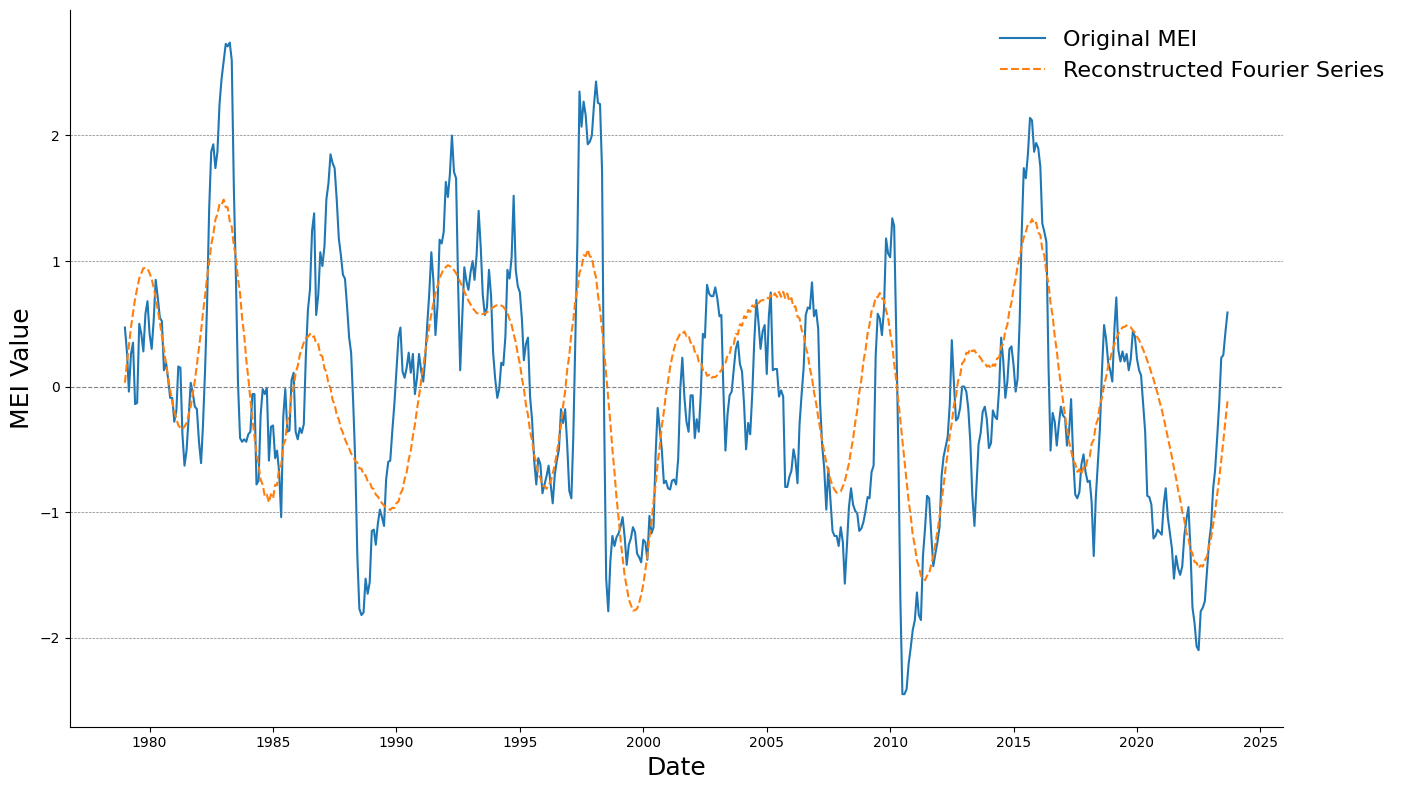

In [82]:
# Select the top 5 frequencies, No 0 since this is overall trend
top_frequencies = fft_df_sorted[fft_df_sorted['Frequency'] > 0].head(5)
top_indices = fft_df_sorted[fft_df_sorted['Frequency'] > 0].head(5).index

# Create a new series of Fourier coefficients where all but the top components are set to zero
filtered_fft_values = np.zeros_like(yf)
for i in top_indices:
    filtered_fft_values[i] = yf[i]
    filtered_fft_values[-i] = yf[-i]  # Include the complex conjugate for inverse FFT (imaginary numbers are mirrored and should be added)

# Perform the inverse FFT to reconstruct the time series using the top components/feqs
reconstructed_series = irfft(filtered_fft_values, n=N)

# Plot the original MEI time series and the reconstructed Fourier series
plt.figure(figsize=(14, 8))
plt.plot(enso_df.index, enso_df['MEI'], label='Original MEI')
plt.plot(enso_df.index, reconstructed_series, label='Reconstructed Fourier Series', linestyle='--')
plt.legend()
# plt.title('MEI Time Series with Reconstructed Fourier Series', fontsize=16)
plt.xlabel('Date', fontsize=18)
plt.ylabel('MEI Value', fontsize=18)
legend = plt.legend(bbox_to_anchor=(1.1, 1), frameon=False, fontsize=16)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=-1, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=2, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=-2, color='gray', linestyle='--', linewidth=0.5)
# plt.xticks(rotation=45)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('../Plots/MEI_Fourier.png')
plt.show()

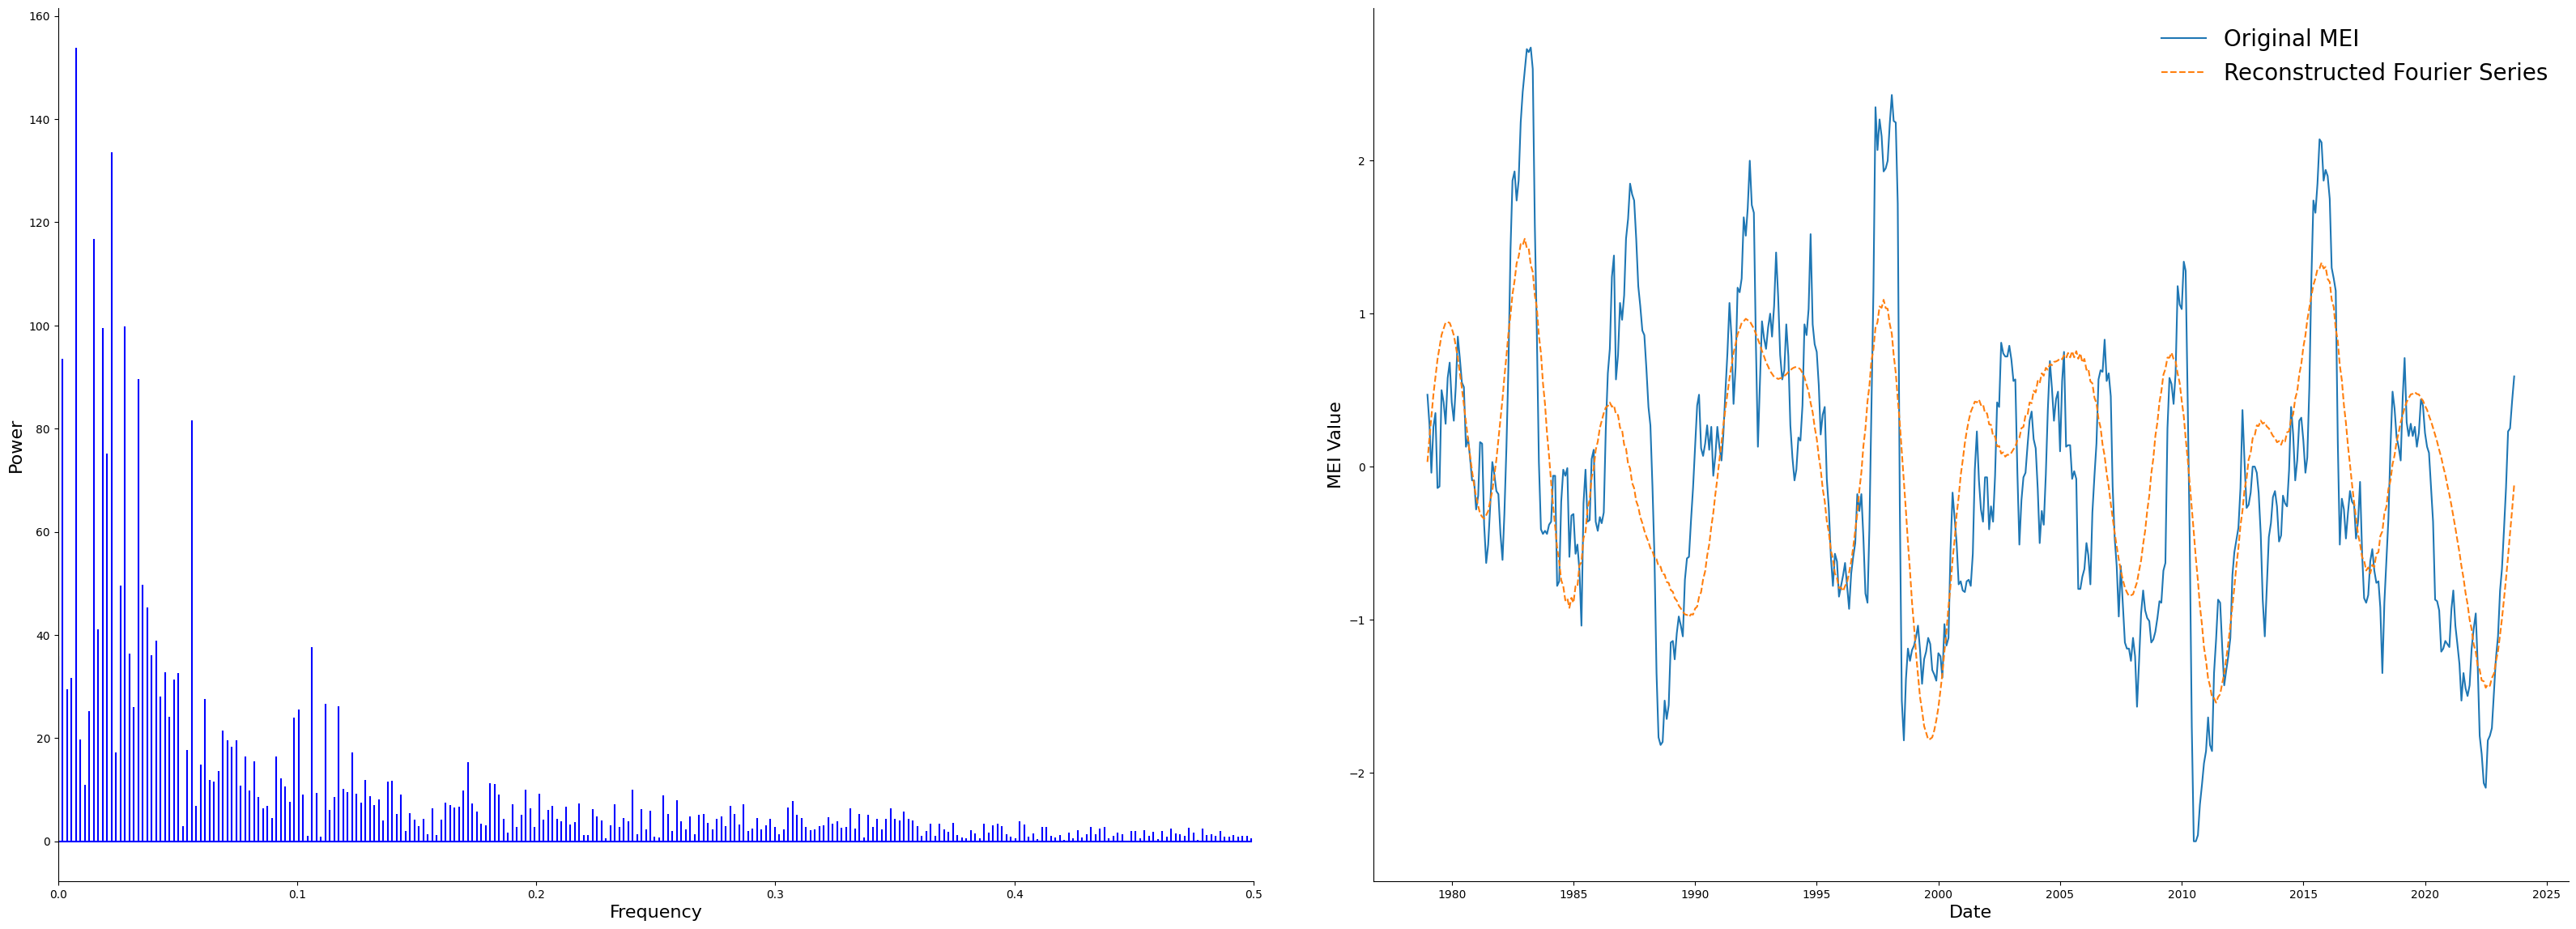

In [8]:
#Plot side by side above
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 14))
ax1.stem(xf, spectrum, 'b', markerfmt=" ", basefmt="-b")
# ax1.set_title('Power Spectrum of the Cleaned MEI Data', fontsize = 16)
ax1.set_xlabel('Frequency', fontsize=16)
ax1.set_ylabel('Power', fontsize=16)
ax1.set_xlim(0, 0.5)  # Only plot the positive frequencies
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.plot(enso_df.index, enso_df['MEI'], label='Original MEI')
ax2.plot(enso_df.index, reconstructed_series, label='Reconstructed Fourier Series', linestyle='--')
ax2.legend(frameon=False, fontsize=20)

# ax2.set_title('MEI Time Series with Reconstructed Fourier Series', fontsize=16)
ax2.set_xlabel('Date', fontsize=16)
ax2.set_ylabel('MEI Value', fontsize=16)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.subplots_adjust(wspace=0.1)  # Adjust this parameter to bring plots closer
plt.savefig('../Plots/fft_fourier.png')
plt.show()

## ARIMAX(1,1,1)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.54243D-02    |proj g|=  1.32081D-01

At iterate    5    f=  7.93191D-02    |proj g|=  4.84421D-02

At iterate   10    f=  7.89535D-02    |proj g|=  8.15648D-04

At iterate   15    f=  7.89527D-02    |proj g|=  6.26495D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     22      1     0     0   2.341D-06   7.895D-02
  F =   7.8952703965760096E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


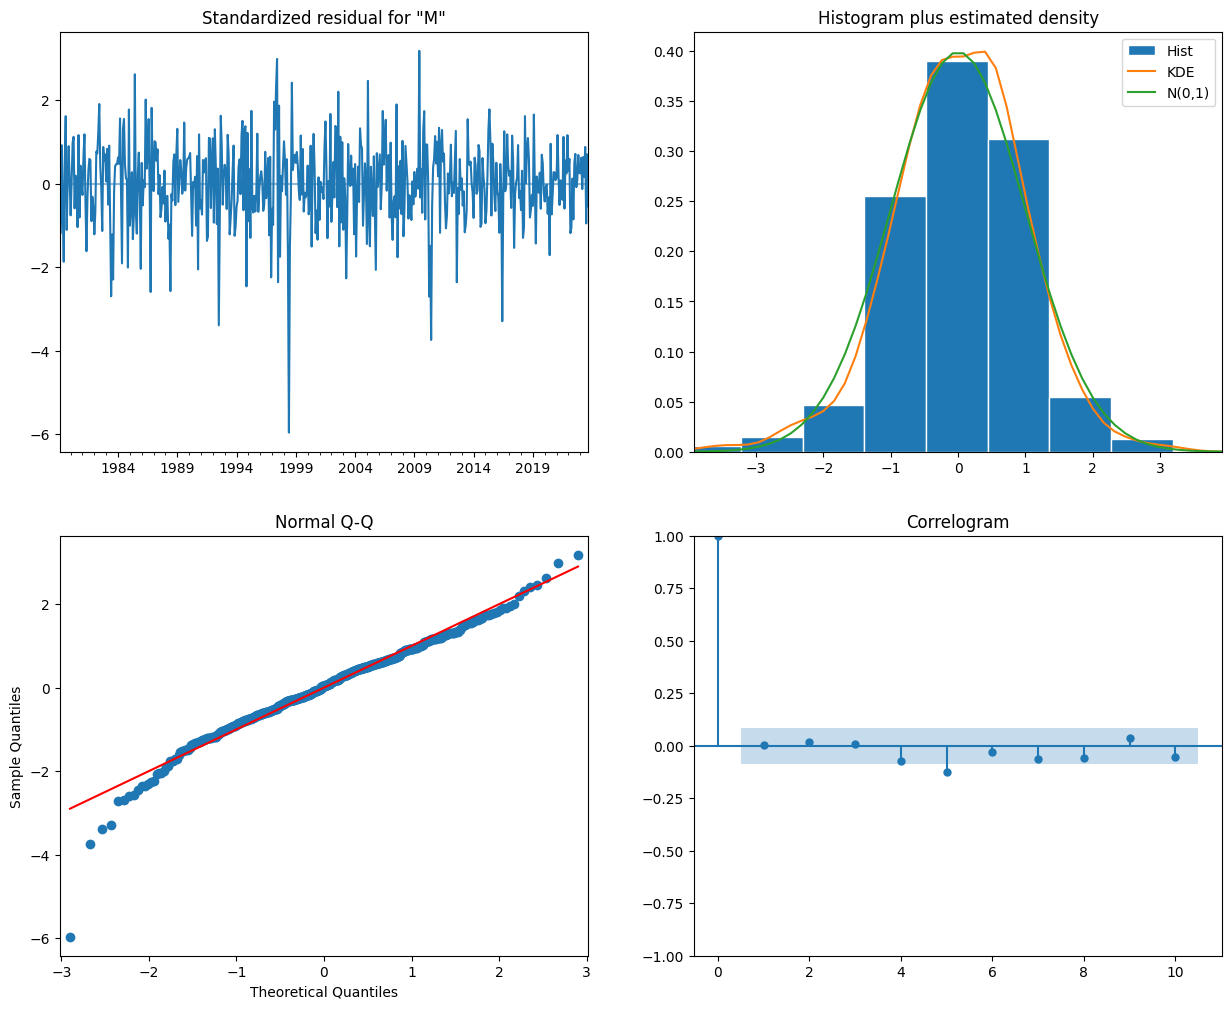

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    MEI   No. Observations:                  537
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -42.398
Date:                Thu, 30 Nov 2023   AIC                             92.795
Time:                        21:40:05   BIC                            109.932
Sample:                    01-01-1979   HQIC                            99.499
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0023      0.116      8.609      0.000       0.774       1.231
ar.L1         -0.2969      0.062     -4.772      0.000      -0.419      -0.175
ma.L1          0.7876      0.043     18.450      0.000       0.704       0.871
sigma2         0.0685      0.003     22.902      0.000       0.063       0.074
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               198.42
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.62
Prob(H) (two-sided):                  0.13   Kurtosis:                         5.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &       MEI        & \textbf{  No. Observations:  } &    537      \\
\textbf{Model:}                  & SARIMAX(1, 1, 1) & \textbf{  Log Likelihood     } &  -42.398    \\
\textbf{Date:}                   & Thu, 30 Nov 2023 & \textbf{  AIC                } &   92.795    \\
\textbf{Time:}                   &     21:40:06     & \textbf{  BIC                } &  109.932    \\
\textbf{Sample:}                 &    01-01-1979    & \textbf{  HQIC               } &   99.499    \\
\textbf{}                        &   - 09-01-2023   & \textbf{                     } &             \\
\textbf{Covariance Type:}        &       opg        & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{x1}     &       1.0023  &        0.116     &  

In [9]:
# Fit an ARIMAX model using the ARIMA(1,0,1) specification with the seasonal components
from statsmodels.tsa.statespace.sarimax import SARIMAX
arimax_model = SARIMAX(enso_df['MEI'], exog=reconstructed_series, order=(1, 1, 1))
arimax_result = arimax_model.fit()

# Plot the diagnostics for the ARIMAX model
fig = arimax_result.plot_diagnostics(figsize=(15, 12)) # type: ignore
# plt.savefig('../Plots/ARIMA_111_ex.png')
plt.show()

# Return the summary of the ARIMAX model as well
arimax_result_summary = arimax_result.summary() # type: ignore

display(arimax_result_summary)
#Return latex arimax_result_summary
print(arimax_result.summary().as_latex())

## Forecast

### Fourier 

In [10]:
forecast_months = 4*12 # 4 years phase

# Extracting the dominant frequencies, amplitudes, and corresponding phases from the FFT
dominant_frequencies = fft_df_sorted.iloc[top_indices]['Frequency'].values
amplitudes = fft_df_sorted.iloc[top_indices]['Amplitude'].values

scaled_amplitudes = amplitudes / (N / 2)
phases = np.angle(yf[top_indices])

# Time vector for the forecast
time_vector_48 = np.arange(N, N + forecast_months) * T

# Function to construct the time series from the Fourier components
def construct_fourier_series(time_vector, frequencies, scaled_amplitudes, phases):
    time_series = np.zeros_like(time_vector, dtype=float)
    for i in range(len(frequencies)):
        frequency = frequencies[i]
        amplitude = scaled_amplitudes[i]
        phase = phases[i]
        time_series += amplitude * np.cos(2 * np.pi * frequency * time_vector + phase)
    return time_series

# Construct the 12-period and 60-period forecasts
forecast_48_periods = construct_fourier_series(time_vector_48, dominant_frequencies, scaled_amplitudes, phases)

# Check if the first 12 values of the 60-period forecast match the 12-period forecast
forecast_48_periods

array([-0.12259616, -0.02287234,  0.07648903,  0.17355987,  0.26648508,
        0.35352574,  0.43309897,  0.50381327,  0.5644984 ,  0.61422893,
        0.65234097,  0.67844146,  0.69241006,  0.69439356,  0.68479306,
        0.66424451,  0.63359333,  0.59386381,  0.54622456,  0.49195103,
        0.43238633,  0.36890169,  0.30285781,  0.23556822,  0.16826598,
        0.10207458,  0.0379839 , -0.023168  , -0.08070692, -0.13412804,
       -0.18309507, -0.22743308, -0.26711554, -0.30224629, -0.33303714,
       -0.35978213, -0.3828296 , -0.40255319, -0.419323  , -0.43347804,
       -0.44530129, -0.45499818, -0.46267961, -0.46835019, -0.47190215,
       -0.47311548, -0.47166412, -0.46712836])

### ARIMAX

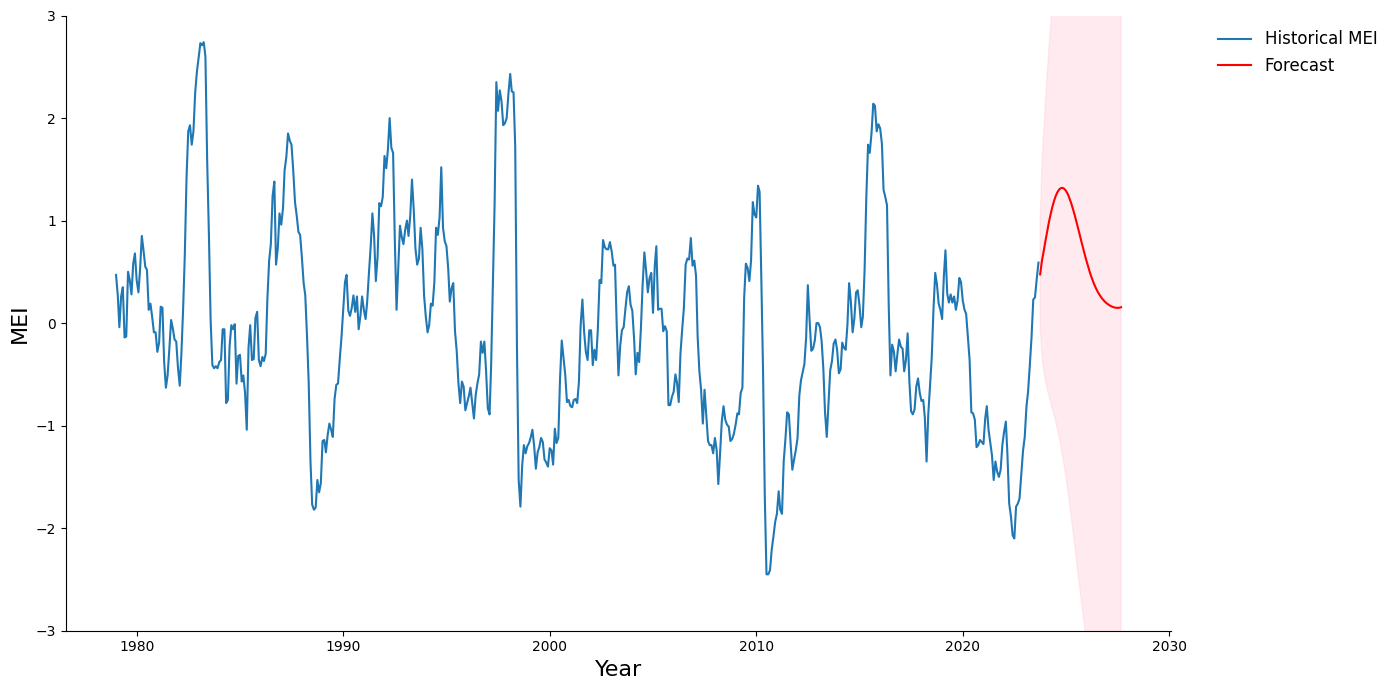

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
# Assuming enso_df and arimax_result are defined and available here
# Get the last known value of the non-differenced series
last_known_value = enso_df['MEI'].iloc[-1]


forecast_steps = forecast_months  # 5 years * 12 months per year
forecast = arimax_result.get_forecast(steps=forecast_steps, exog = forecast_48_periods)
# Get the forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the historical MEI data along with the forecast and confidence intervals
plt.figure(figsize=(14, 7))

# Plot the historical data
plt.plot(enso_df['MEI'], label='Historical MEI')

# Plot the forecasted data
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')

# Plot the confidence intervals
plt.fill_between(forecast_conf_int.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.ylim(-3, 3)
# plt.title('5-Year Forecast of MEI using Fourier ARIMAX(1, 1, 1) Model', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.ylabel('MEI', fontsize=16)
plt.legend()
legend = plt.legend(bbox_to_anchor=(1.2, 1), frameon=False, fontsize='large')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('../Plots/ARIMA_111_ex_forecast.png', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()


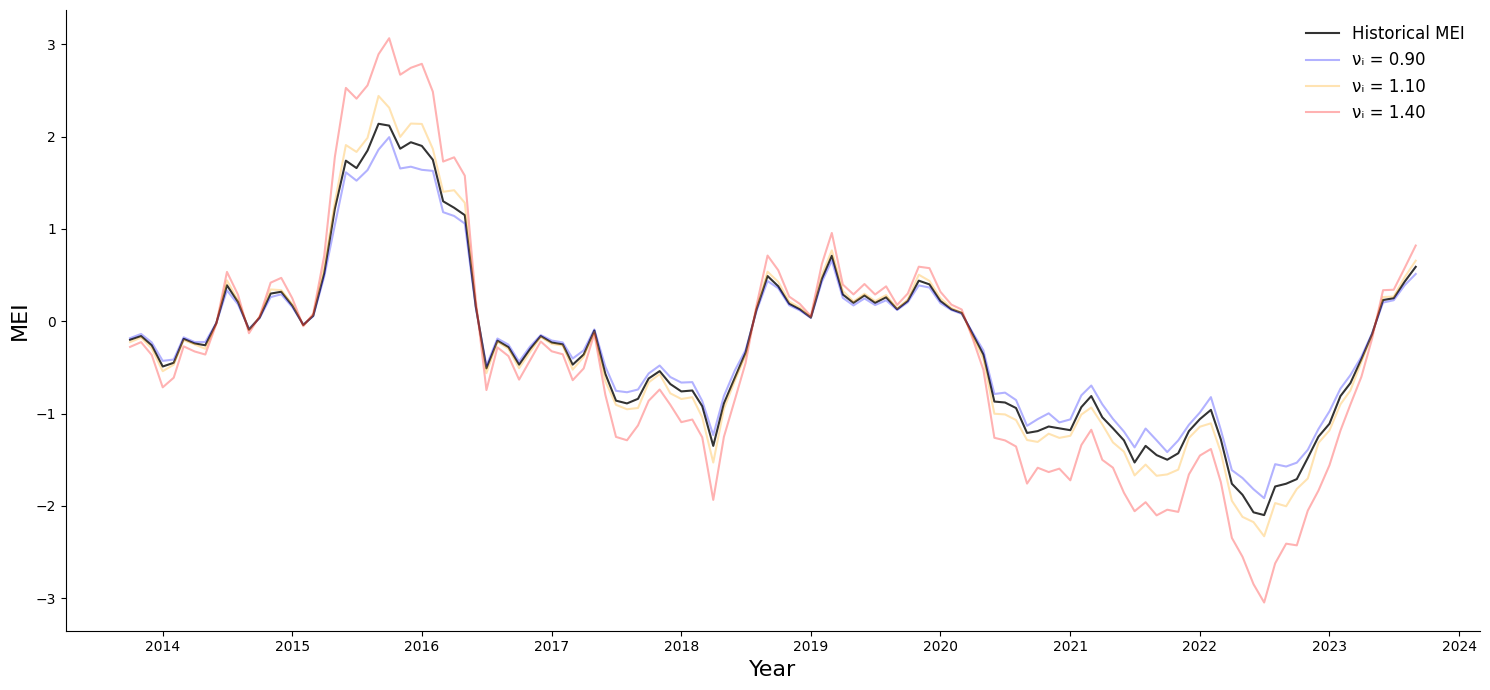

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import random

# Set the random seed for reproducibility
random.seed(42)

# Define the range of intensity factors
intensity_factors = [0.9, 1.1, 1.4]

# Select the last 10 years of historical data
last_10_years = enso_df[-120:]  # Assuming monthly data

# Create a DataFrame to hold the scenarios
scenarios_df = pd.DataFrame(index=last_10_years.index)

# Generate scenarios with increasing intensity factors
for factor in intensity_factors:
    scenario_name = f"νᵢ = {factor:.2f}"
    intensified_values = last_10_years['MEI'].copy()
    
    # Intensify both positive and negative values
    intensified_values[intensified_values > 0] *= factor
    intensified_values[intensified_values < 0] *= factor
    
    # Assign to the scenarios dataframe
    scenarios_df[scenario_name] = intensified_values
    
    # Optionally, introduce additional random fluctuations for each month
    for i in range(len(scenarios_df[scenario_name])):
        random_fluctuation = random.uniform(0.95, 1.05)
        scenarios_df[scenario_name].iloc[i] *= random_fluctuation

# Plot the historical data and the intense phase scenarios
plt.figure(figsize=(20, 7))
plt.plot(last_10_years['MEI'], label='Historical MEI', color='black', alpha=0.8)

colors = ['blue', 'orange', 'red']  # Color for each scenario
# Plot each of the intense ENSO phase scenarios
for i, (column, color) in enumerate(zip(scenarios_df.columns, colors)):
    plt.plot(scenarios_df.index, scenarios_df[column], label=column, linestyle='-', alpha=0.3, color=color)

# Add title, labels, and legend
plt.xlabel('Year', fontsize=16)
plt.ylabel('MEI', fontsize=16)
legend = plt.legend(bbox_to_anchor=(1, 1), frameon=False, fontsize='large')
plt.tight_layout(rect=[0, 0, 0.75, 1])

# Remove top and right border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../Plots/ENSO_intense_phases.png', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()


[1.1, 1.3, 1.5]

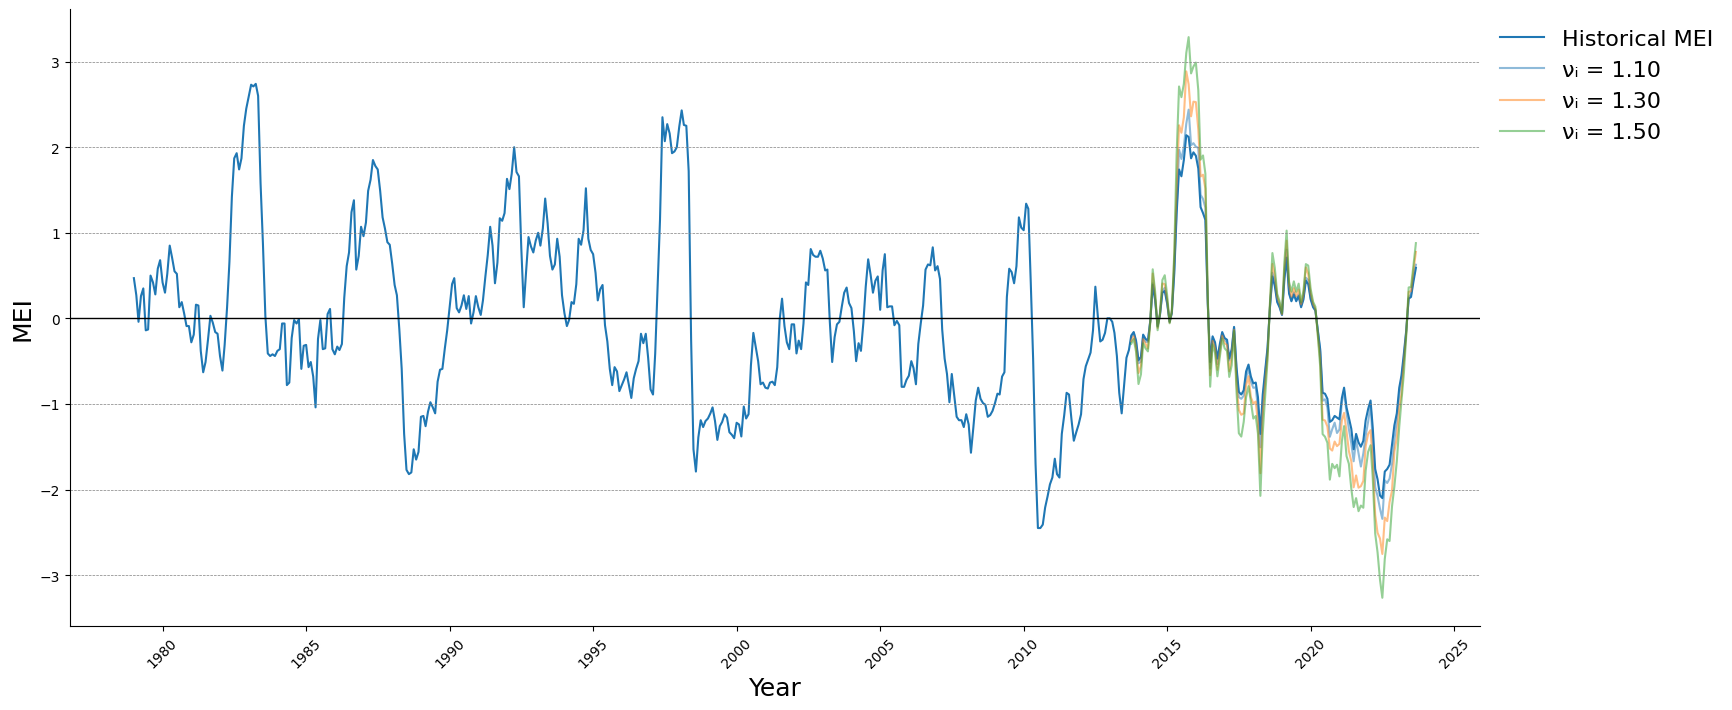

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import random

# Set the random seed for reproducibility
random.seed(42)


# Get the fitted values from the model for the last 10 years

# Define the range of intensity factors
intensity_factors = [1.1, 1.3 ,1.5]
#create an array of intensity factors from 1 to 2 by 0.1
# intensity_factors = np.arange(0.9, 2, 0.1)
display(intensity_factors)
# Select the last 10 years of historical data to apply the simulation
simulation_start = -120  # Last 10 years assuming monthly data
fitted_values = arimax_result.fittedvalues[simulation_start:]
last_10_years = enso_df[simulation_start:]

# Create a DataFrame to hold the scenarios, only for the last 10 years
scenarios_df = pd.DataFrame(index=last_10_years.index)
scenarios_df = pd.DataFrame(index=fitted_values.index)
# Generate scenarios with increasing intensity factors
for factor in intensity_factors:
    scenario_name = f"νᵢ = {factor:.2f}"
    intensified_values = last_10_years['MEI'].copy()
    
    # Intensify both positive and negative values
    intensified_values[intensified_values > 0] *= factor
    intensified_values[intensified_values < 0] *= factor
    
    # Optionally, introduce additional random fluctuations for each month
    for i in range(len(intensified_values)):
        random_fluctuation = random.uniform(0.95, 1.05)
        intensified_values.iloc[i] *= random_fluctuation
    
    # Assign to the scenarios dataframe
    scenarios_df[scenario_name] = intensified_values

# Plot the entire historical data
plt.figure(figsize=(20, 7))
plt.plot(enso_df.index, enso_df['MEI'], label='Historical MEI', color='C0')

colors = ['blue', 'orange', 'red']
# Plot each of the intense ENSO phase scenarios for the last 10 years
for i, (column, color) in enumerate(zip(scenarios_df.columns, colors)):
    plt.plot(scenarios_df.index, scenarios_df[column], label=column, linestyle='-', alpha=0.5)

# Add title, labels, and legend
plt.xlabel('Year', fontsize=18)
plt.ylabel('MEI', fontsize=18)
legend = plt.legend(bbox_to_anchor=(1, 1), frameon=False, fontsize=16)
plt.tight_layout(rect=[0, 0, 0.75, 1])
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=-1, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=2, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=-2, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=3, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=-3, color='gray', linestyle='--', linewidth=0.5)
# Remove top and right border
plt.xticks(rotation=45)
# Remove top and right border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../Plots/ENSO_intense_phases_full_timeseries.png', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()


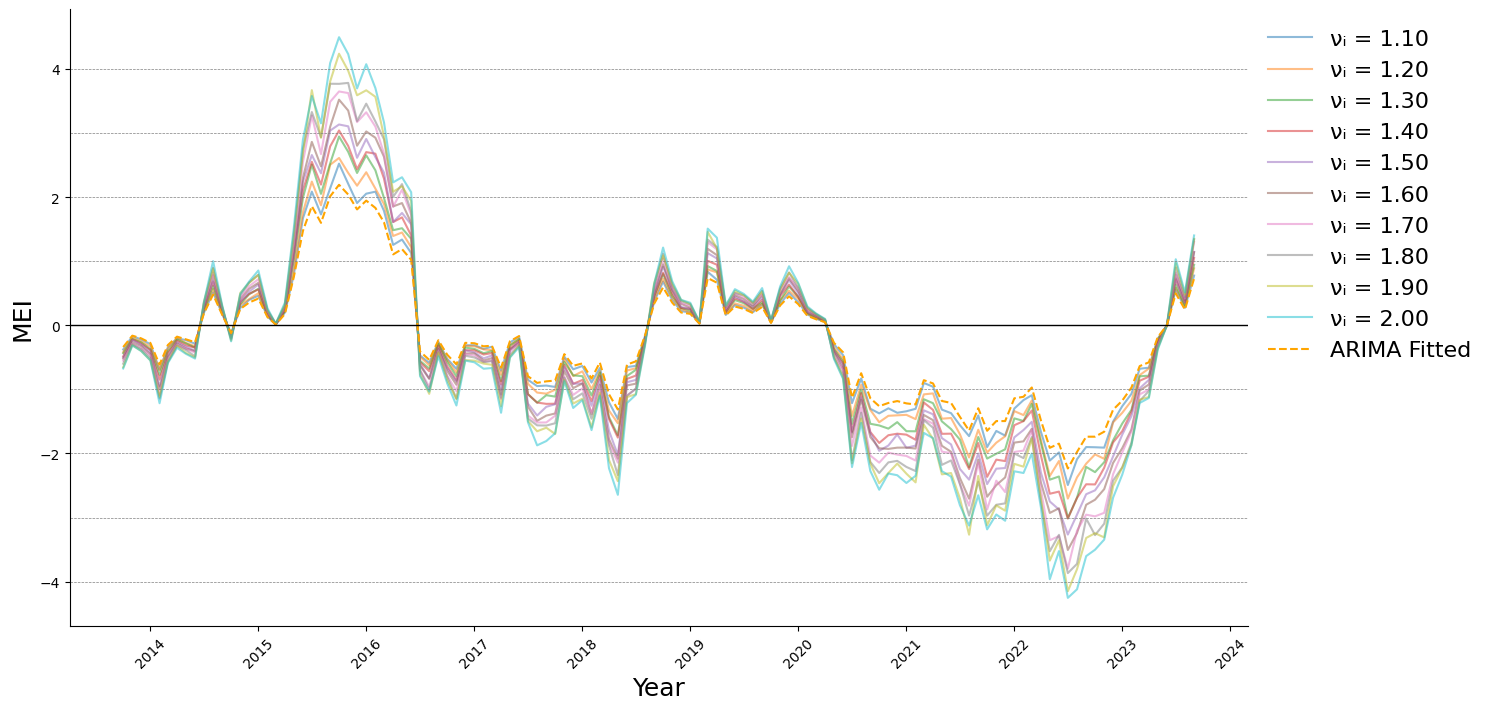

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Your ARIMAX fitting code here
# For example:
# arimax_model = SARIMAX(enso_df['MEI'], exog=reconstructed_series, order=(1, 1, 1))
# arimax_result = arimax_model.fit()

# Set the random seed for reproducibility
random.seed(42)

# Generate intensity factors from 1.1 to 2.0 with steps of 0.1
intensity_factors = np.arange(1.1, 2.1, 0.1)
plot_historical_data = False  # Set to False to only plot the scenarios
# Select the last 10 years of historical data to apply the simulation
simulation_start = -120  # Assuming monthly data
fitted_values = arimax_result.fittedvalues[simulation_start:]
last_10_years = enso_df[simulation_start:]

# Create a DataFrame to hold the scenarios, only for the last 10 years
scenarios_df = pd.DataFrame(index=fitted_values.index)

# Generate scenarios with increasing intensity factors
for factor in intensity_factors:
    scenario_name = f"νᵢ = {factor:.2f}"
    intensified_values = fitted_values.copy()
    
    # Intensify both positive and negative values
    intensified_values[intensified_values > 0] *= factor
    intensified_values[intensified_values < 0] *= factor
    
    # Optionally, introduce additional random fluctuations for each month
    for i in range(len(intensified_values)):
        random_fluctuation = random.uniform(0.95, 1.05)
        intensified_values.iloc[i] *= random_fluctuation
    
    # Assign to the scenarios dataframe
    scenarios_df[scenario_name] = intensified_values

# Plot the entire historical data
plt.figure(figsize=(20, 7))

if plot_historical_data:
    plt.plot(enso_df.index, enso_df['MEI'], label='Historical MEI', color='C0')

# Plot each of the intense ENSO phase scenarios for the last 10 years
for column in scenarios_df.columns:
    plt.plot(scenarios_df.index, scenarios_df[column], label=column, linestyle='-', alpha=0.5)

plt.plot(last_10_years.index, fitted_values, label='ARIMA Fitted', color='orange', linestyle='--')
# Add title, labels, and legend
plt.xlabel('Year', fontsize=18)
plt.ylabel('MEI', fontsize=18)
legend = plt.legend(bbox_to_anchor=(1, 1), frameon=False, fontsize=16)
plt.tight_layout(rect=[0, 0, 0.75, 1])
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=-1, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=2, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=-2, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=3, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=-3, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=4, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=-4, color='gray', linestyle='--', linewidth=0.5)
# Remove top and right border
plt.xticks(rotation=45)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../Plots/ENSO_intense_phases_full_timeseries_varied_intensity.png', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()


## Scenarios

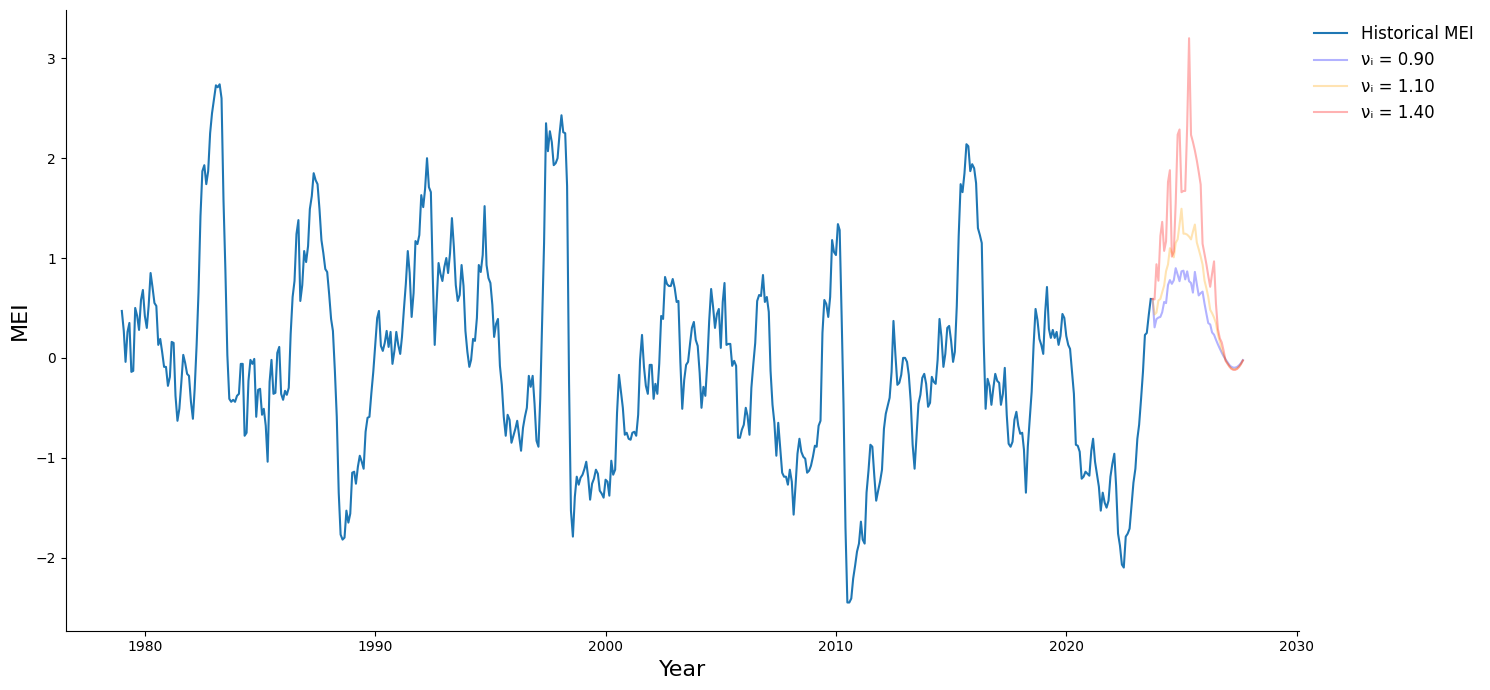

In [97]:
import matplotlib.pyplot as plt
import pandas as pd
import random

# Set the random seed for reproducibility
random.seed(42)

# Define the range of intensity factors
intensity_factors = [0.9, 1.1, 1.4]
# intensity_factors = np.arange(0.9, 1.4, 0.05)

# Create a DataFrame to hold the scenarios
scenarios_df = pd.DataFrame(index=forecast_mean.index)
duration_extension = 4
# Generate scenarios with increasing intensity factors
for factor in intensity_factors:
    scenario_name = f"νᵢ = {factor:.2f}"
    scenarios_df[scenario_name] = forecast_mean * (0.8 + random.uniform(0, factor - 1))
    
    for i in range(len(scenarios_df[scenario_name]) - duration_extension):
        if scenarios_df[scenario_name].iloc[i] > 0:
            extension = random.uniform(0, duration_extension)
            scenarios_df[scenario_name].iloc[i:i+int(extension)] *= factor
        if i == 0:
            scenarios_df[scenario_name].iloc[i] = enso_df['MEI'].iloc[-1]



# Plot the historical data and the base forecast
plt.figure(figsize=(20, 7))
plt.plot(enso_df['MEI'], label='Historical MEI')
# plt.plot(forecast_mean.index, forecast_mean, label='Base Forecast', color='red', alpha = 0.8)
color = ['blue', 'orange', 'red']
# Plot each of the intense El Niño scenarios
for i, column in enumerate(scenarios_df.columns):
    if i <= 2:
        plt.plot(scenarios_df.index, scenarios_df[column], label=column, linestyle='-', alpha = 0.3, color = color[i])
    else:
        plt.plot(scenarios_df.index, scenarios_df[column], label=column, linestyle='-', alpha = 0.3)
# Add title, labels, and legend
# plt.title('Forecast of MEI.v2 with Multiple El Niño Scenarios', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.ylabel('MEI', fontsize=16)
#plot legend outside of the plot no box
legend = plt.legend(bbox_to_anchor=(1, 1), frameon=False, fontsize='large')
plt.tight_layout(rect=[0, 0, 0.75, 1])

# Save the figure with the legend included

#remove top and right border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('../Plots/ARIMA_111_scen_3.png', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

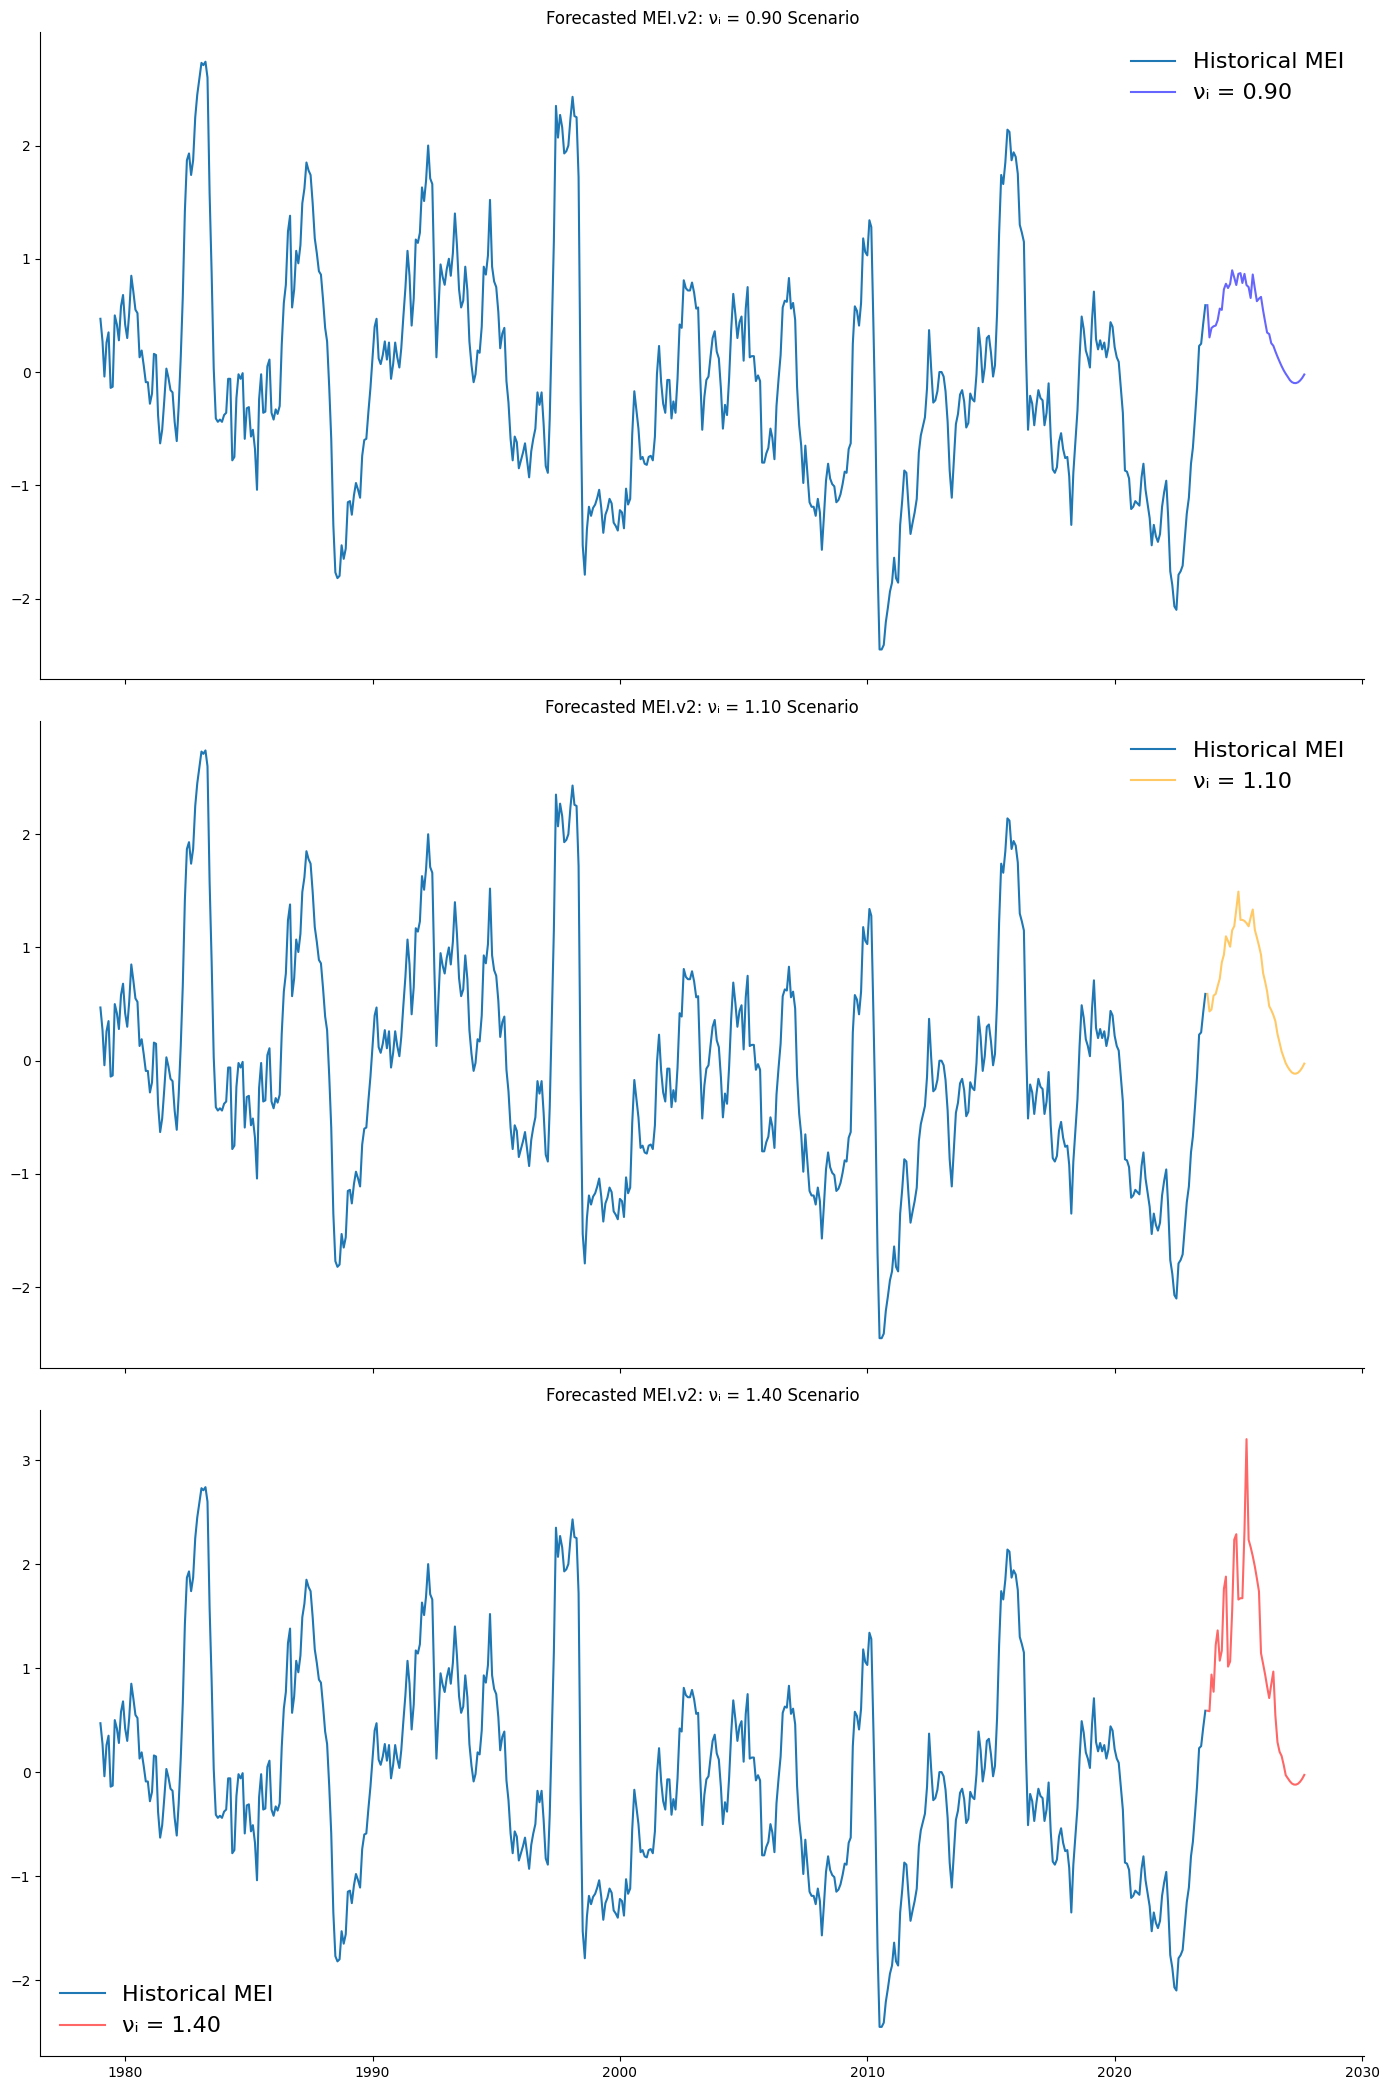

In [101]:
fig, axs = plt.subplots(len(scenarios_df.columns), 1, figsize=(14, 7 * (len(scenarios_df.columns))), sharex=True)
color = ['blue', 'orange', 'red']
# Plot each scenario
for i, column in enumerate(scenarios_df.columns, start=0):
    axs[i].plot(enso_df.index, enso_df['MEI'], label='Historical MEI')
    axs[i].plot(scenarios_df.index, scenarios_df[column], label=column, color=color[i], alpha=0.6)
    axs[i].set_title(f'Forecasted MEI.v2: {column} Scenario')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].legend(frameon=False, fontsize=16)

plt.tight_layout()
plt.savefig('../Plots/ARIMA_111_scen_3_subplot.png')
plt.show()

### Save

In [15]:
#Extract Predicted values
forecast_dates = forecast_mean.index
forecast_values = forecast_mean.values

# Create a dictionary to hold dates and values for each scenario
scenarios_data = {}

for scenario in scenarios_df.columns:
    # Extract the MEI values for the scenario
    scenario_values = scenarios_df[scenario].values
    # Store the dates and values in the dictionary
    scenarios_data[scenario] = {
        'dates': forecast_dates,
        'values': scenario_values
    }
#Create one dataframe for all scenarios with key as column name
scenarios_df = pd.DataFrame(scenarios_data)
scenarios_df.head()
#Save to pickle
# scenarios_df.to_pickle('../Data/scenarios_df.pkl')